#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [ ]:
traindata = pd.read_csv(path + 'data01_train.csv')
traindata = traindata.drop(columns='subject')
traindata.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
testdata = pd.read_csv(path + 'data01_test.csv')
testdata = testdata.drop(columns='subject')
testdata.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [ ]:
featuresdata = pd.read_csv(path + 'features.csv')
featuresdata.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [ ]:
traindata.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
traindata.dtypes

,0
tBodyAcc-mean()-X,float64
tBodyAcc-mean()-Y,float64
tBodyAcc-mean()-Z,float64
tBodyAcc-std()-X,float64
tBodyAcc-std()-Y,float64
...,...
"angle(tBodyGyroJerkMean,gravityMean)",float64
"angle(X,gravityMean)",float64
"angle(Y,gravityMean)",float64
"angle(Z,gravityMean)",float64


In [ ]:
traindata.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
traindata.isna().sum().value_counts()

,count
0,562


In [ ]:
# traindata.corr(numeric_only=True).style.background_gradient()

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [ ]:
traindata['Activity'].unique()

array(['STANDING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

In [ ]:
traindata['Activity'].value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


In [ ]:
traindata['Activity'].value_counts(normalize=True)*100

,proportion
Activity,
LAYING,18.959361
STANDING,18.483251
SITTING,17.548036
WALKING,16.969903
WALKING_UPSTAIRS,14.589356
WALKING_DOWNSTAIRS,13.450094


<ipython-input-16-cdb45e7ce55c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=traindata, x='Activity', order=sorted_order, palette='Blues')


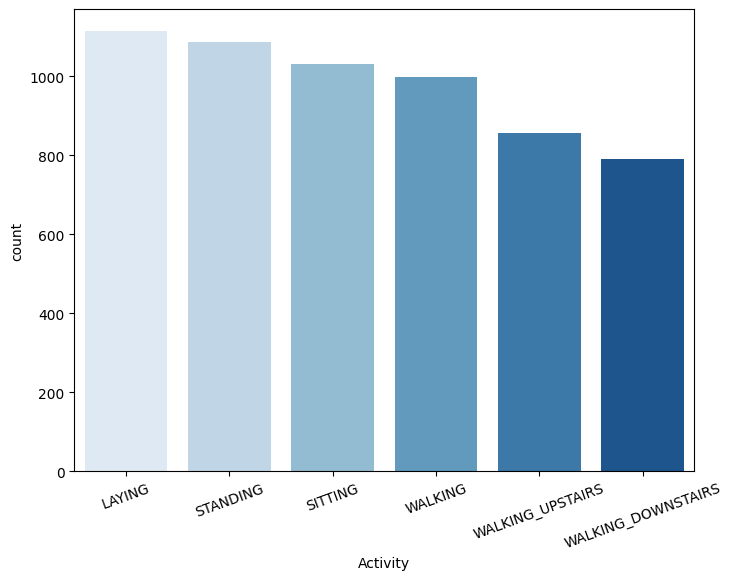

In [ ]:
sorted_order = traindata['Activity'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(8, 6))
sns.countplot(data=traindata, x='Activity', order=sorted_order, palette='Blues')
plt.xticks(rotation=20)

plt.show()
# 동적 데이터보다 정적 데이터개수가 더 많음.
# 데이터 셋 내에서 클래스 간의 불균형이 관찰되지 않으며, 모든 클래스의 데이터 분포가 비교적 균일하다.
# 따라서 추가적인 불균형 처리나 클래스 가중치 조정과 같은 전처리 과정은 필요하지 않다.

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [ ]:
target = 'Activity'
x = traindata.drop(columns=target)
y = traindata.loc[:, target]

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=20)

#### 2) 모델링

In [ ]:
premodel = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=1)

premodel.fit(x_train, y_train)

pred = premodel.predict(x_val)

In [ ]:
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

# confusion_matrix 분석 결과, 동적과 정적 각 클래스 내의 분류 오차는 존재하나, 동적과 정적 클래스 간의 분류 오차는 존재하지 않는다. = 동적/정적 분류는 쉽게 수행할 수 있다.
# LAYING 클래스는 분류 정확도가 매우 높으며, 이는 해당 데이터가 명확하여 비교적 쉽게 분류될 수 것이라 추정된다.
# 전체적으로 봤을 때, 정정 클래스 내의 분류 오차가 동적 클래스 내의 분류 오차보다 상대적으로 더 크게 나타난다.

[[202   0   0   0   0   0]
 [  0 193  18   0   0   0]
 [  0  20 194   0   0   0]
 [  0   0   0 195   4   4]
 [  0   0   0  10 154   6]
 [  0   0   0   5   6 166]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       202
           SITTING       0.91      0.91      0.91       211
          STANDING       0.92      0.91      0.91       214
           WALKING       0.93      0.96      0.94       203
WALKING_DOWNSTAIRS       0.94      0.91      0.92       170
  WALKING_UPSTAIRS       0.94      0.94      0.94       177

          accuracy                           0.94      1177
         macro avg       0.94      0.94      0.94      1177
      weighted avg       0.94      0.94      0.94      1177



#### 3) 변수 중요도 추출

In [ ]:
all = plot_feature_importance(premodel.feature_importances_, x_train.columns, result_only = True, topn = 'all')
print(all)
#사용된 피처에 대한 중요도 정렬

                       feature_name  feature_importance
0              angle(X,gravityMean)            0.045171
1            tGravityAcc-energy()-X            0.040752
2               tGravityAcc-min()-X            0.035754
3              tGravityAcc-mean()-X            0.028686
4               tGravityAcc-max()-X            0.025715
..                              ...                 ...
556  fBodyAcc-bandsEnergy()-33,48.2            0.000000
557          tBodyAcc-arCoeff()-X,1            0.000000
558           fBodyAccJerk-mean()-Y            0.000000
559            tBodyAcc-entropy()-Z            0.000000
560               tBodyAcc-mean()-X            0.000000

[561 rows x 2 columns]


,feature_name,feature_importance
0,"angle(X,gravityMean)",0.045171
1,tGravityAcc-energy()-X,0.040752
2,tGravityAcc-min()-X,0.035754
3,tGravityAcc-mean()-X,0.028686
4,tGravityAcc-max()-X,0.025715


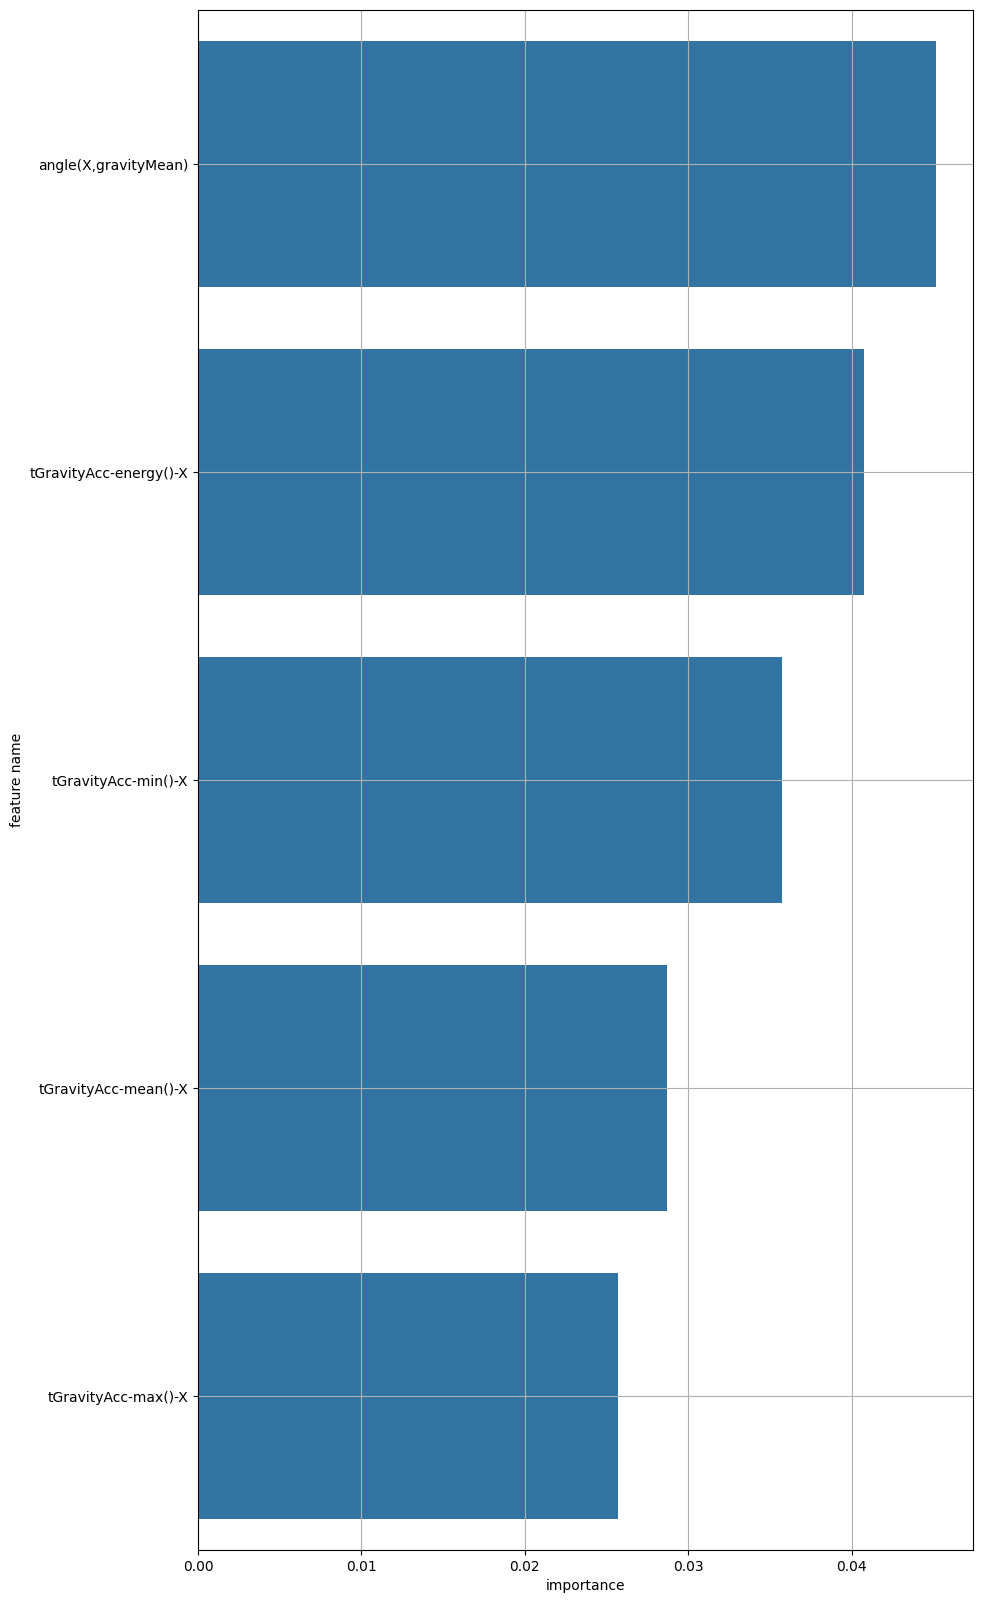

In [ ]:
top5 = plot_feature_importance(premodel.feature_importances_, x_train.columns, result_only = False, topn = 5)
top5
# 중요도 상위 5개 시각화

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [ ]:
top5name = top5['feature_name'].tolist()
top5name

['angle(X,gravityMean)',
 'tGravityAcc-energy()-X',
 'tGravityAcc-min()-X',
 'tGravityAcc-mean()-X',
 'tGravityAcc-max()-X']

In [ ]:
bottom5name = all.tail(5)['feature_name'].tolist()
bottom5name

['fBodyAcc-bandsEnergy()-33,48.2',
 'tBodyAcc-arCoeff()-X,1',
 'fBodyAccJerk-mean()-Y',
 'tBodyAcc-entropy()-Z',
 'tBodyAcc-mean()-X']

In [ ]:
top5bottom5 = traindata[top5name + bottom5name + ['Activity']]
top5bottom5

,"angle(X,gravityMean)",tGravityAcc-energy()-X,tGravityAcc-min()-X,tGravityAcc-mean()-X,tGravityAcc-max()-X,"fBodyAcc-bandsEnergy()-33,48.2","tBodyAcc-arCoeff()-X,1",fBodyAccJerk-mean()-Y,tBodyAcc-entropy()-Z,tBodyAcc-mean()-X,Activity
0,-0.601120,0.673768,0.891969,0.875254,0.805627,-0.999699,0.152665,-0.984515,-0.317703,0.288508,STANDING
1,0.345205,-0.893830,-0.095343,-0.134711,-0.200892,-0.999814,0.006580,-0.991952,-0.360379,0.265757,LAYING
2,-0.833564,0.906252,0.985606,0.965965,0.891615,-0.999863,0.491210,-0.975039,-0.619015,0.278709,STANDING
3,-0.695819,0.805419,0.943954,0.927343,0.858160,-0.953523,-0.600320,-0.222773,-0.045575,0.289795,WALKING
4,-0.705029,0.738738,0.901943,0.901125,0.858531,-0.976019,-0.178059,-0.453353,0.526684,0.394807,WALKING_DOWNSTAIRS
...,...,...,...,...,...,...,...,...,...,...,...
5876,-0.912365,0.925506,0.992398,0.973223,0.899036,-0.999654,0.196935,-0.981233,-0.431012,0.277194,SITTING
5877,-0.690278,0.763412,0.921001,0.910932,0.843681,-0.971970,-0.444424,-0.266231,0.157674,0.191568,WALKING_UPSTAIRS
5878,0.620363,-0.998561,-0.465011,-0.514220,-0.579367,-0.999671,0.139245,-0.986441,-0.580376,0.267981,LAYING
5879,-0.718009,0.790552,0.932387,0.921553,0.852565,-0.976553,-0.719616,-0.340300,0.036822,0.212787,WALKING_UPSTAIRS


#### 2) 상위 5개 변수에 대한 분석

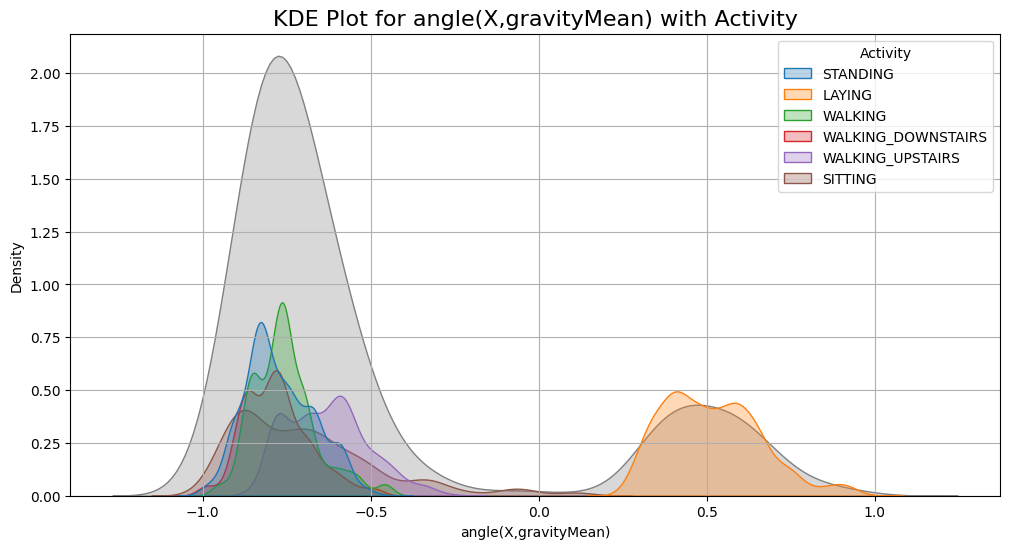

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=top5bottom5, x=top5name[0], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=top5bottom5, x=top5name[0], hue='Activity', fill=True, common_norm=True, alpha=0.3)

plt.title(f'KDE Plot for {top5name[0]} with Activity', fontsize=16)
plt.grid()
plt.show()

# 커널 밀도 추정(Kernel Density Estimation)의 약자로, 확률 밀도 함수(PDF)를 추정하는 비모수적 방법 중 하나
# KDE는 데이터 포인트에 각각 커널(일반적으로 가우시안 분포 곡선)을 씌우고, 이를 모두 더하여 전체 데이터의 분포를 매끄럽게 보여

# 그래프 분포
# angle(X, gravityMean) 피처에서 LAYING 클래스에 속하는 데이터들은 주로 양의 값에 밀집되어 있고, 다른 클래스에 속하는 데이터들은 주로 음의 값에 밀집되어 있다.
# 이 분포를 바탕으로, LAYING 클래스는 해당 피처에서 명확하게 구분되는 패턴을 보이므로, LAYING 클래스를 분류하는 데 중요한 피처일 가능성이 높다고 추정할 수 있다.

# 도메인 지식 관점 분석
# angle(X, gravityMean):  신체의 앞뒤 방향(X축)이 중력 방향의 각도
# 누워있는 상태는 신체의 앞뒤 방향(X축)이 중력과 평행하거나 거의 평행할 때(중력과 동일한 방향) 양의 값이 나타남.
# 그 외는 신체의 앞뒤 방향과 중력과 수직이거나 거의 수직임.

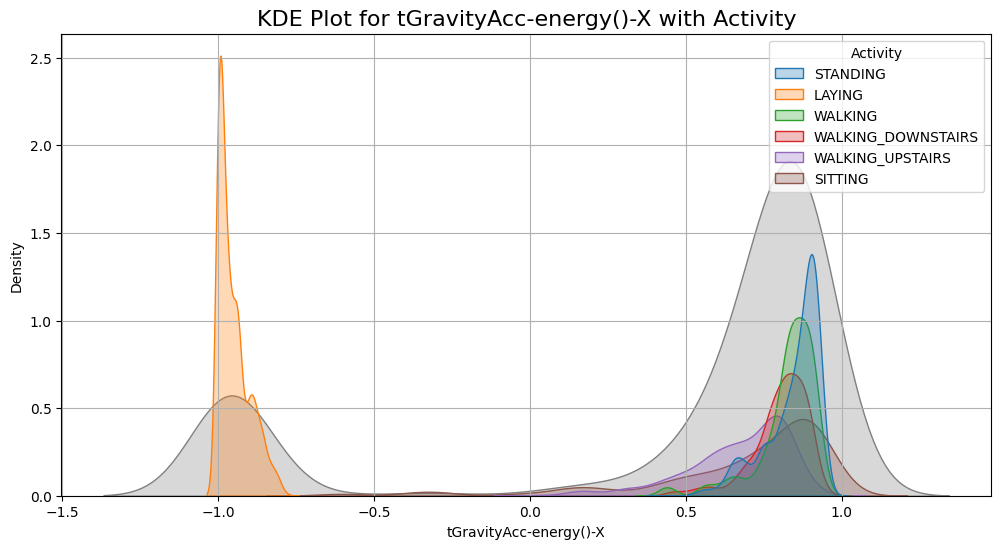

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=top5bottom5, x=top5name[1], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=top5bottom5, x=top5[1], hue='Activity', fill=True, common_norm=True, alpha=0.3)

plt.title(f'KDE Plot for {top5name[1]} with Activity', fontsize=16)
plt.grid()
plt.show()



# 그래프 분포
# tGravityAcc-energy()-X 피처에서 LAYING 클래스에 속하는 데이터들은 주로 음의 값에 밀집되어 있고, 다른 클래스에 속하는 데이터들은 주로 양의 값에 밀집되어 있다.
# 이 분포를 바탕으로, LAYING 클래스는 해당 피처에서 명확하게 구분되는 패턴을 보이므로, LAYING 클래스를 분류하는 데 중요한 피처일 가능성이 높다고 추정할 수 있다.

# 도메인 지식 관점 분석
# tGravityAcc-energy()-X: 사람의 몸 앞뒤 방향(X축)으로 중력이 얼마나 강하게 작용하고 있는지를 나타내는 값
# 누워있는 상태는 신체의 X축 음의 방향으로 중력이 작용 되어 -1값에 밀집되어 있는 것으로 추정


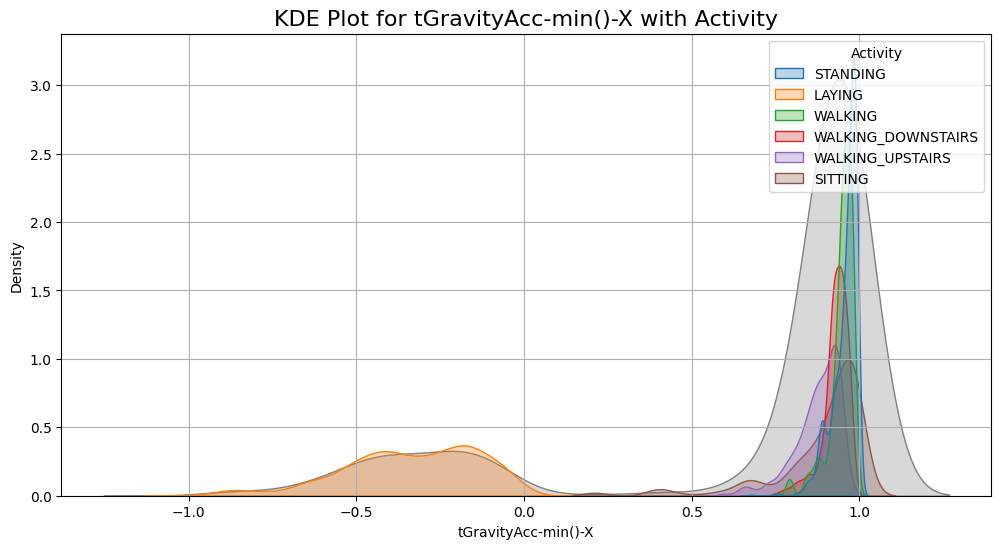

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=top5bottom5, x=top5name[2], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=top5bottom5, x=top5name[2], hue='Activity', fill=True, common_norm=True, alpha=0.3)

plt.title(f'KDE Plot for {top5name[2]} with Activity', fontsize=16)
plt.grid()
plt.show()

# 위와 동일

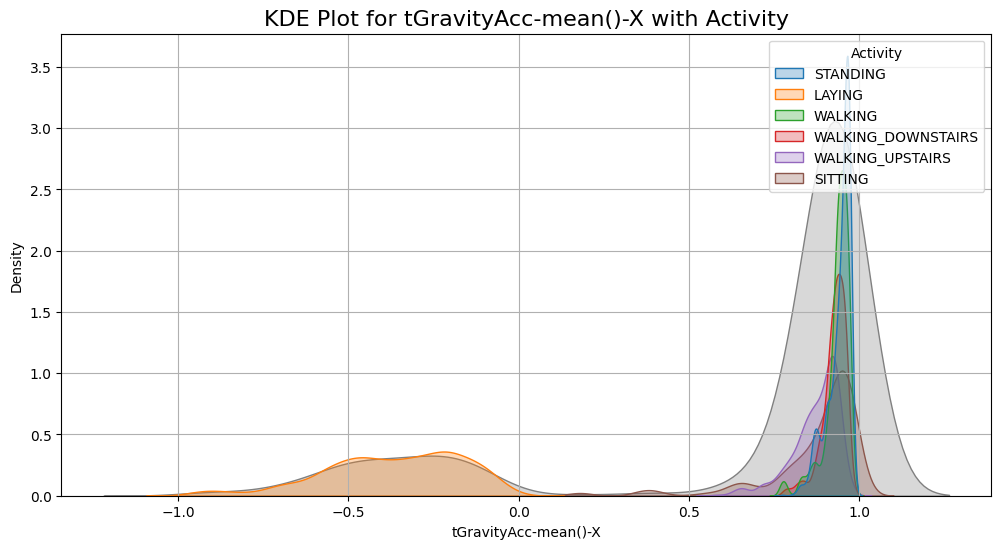

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=top5bottom5, x=top5name[3], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=top5bottom5, x=top5name[3], hue='Activity', fill=True, common_norm=True, alpha=0.3)

plt.title(f'KDE Plot for {top5name[3]} with Activity', fontsize=16)
plt.grid()
plt.show()
# 위와 동일

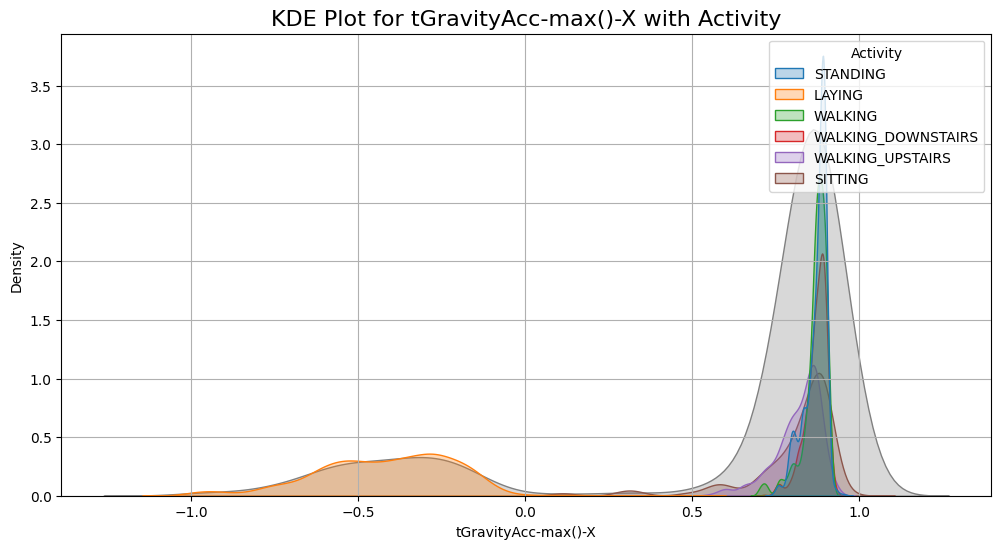

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=top5bottom5, x=top5name[4], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=top5bottom5, x=top5name[4], hue='Activity', fill=True, common_norm=True, alpha=0.3)

plt.title(f'KDE Plot for {top5name[4]} with Activity', fontsize=16)
plt.grid()
plt.show()
# 위와 동일

#### 3) 하위 5개 변수에 대한 분석

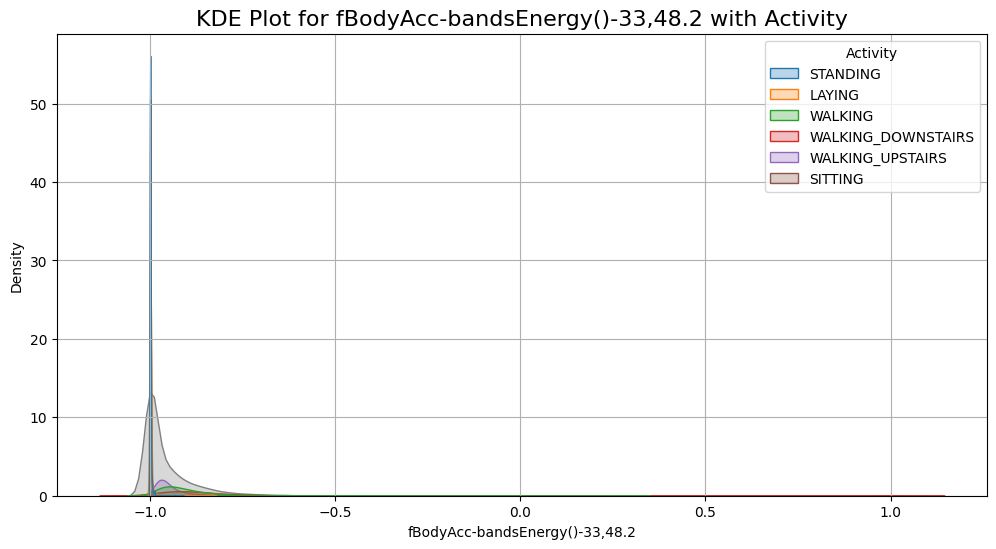

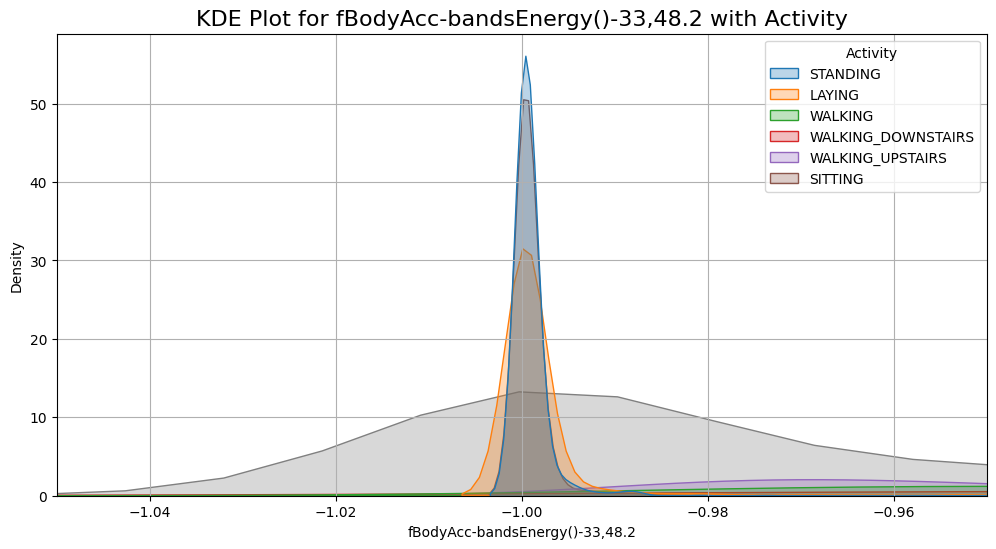

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=top5bottom5, x=bottom5name[0], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=top5bottom5, x=bottom5name[0], hue='Activity', fill=True, common_norm=True, alpha=0.3)
plt.title(f'KDE Plot for {bottom5name[0]} with Activity', fontsize=16)
plt.grid()
plt.show()


plt.figure(figsize=(12, 6))
sns.kdeplot(data=top5bottom5, x=bottom5name[0], color='gray', fill=True,common_norm=False, alpha=0.3)
sns.kdeplot(data=top5bottom5, x=bottom5name[0], hue='Activity',fill=True,common_norm=True, alpha=0.3)
plt.xlim(-1.05, -0.95)
plt.title(f'KDE Plot for {bottom5name[0]} with Activity', fontsize=16)
plt.grid()
plt.show()


# 그래프 분포
# fBodyAcc-bandsEnergy()-33,48.2 피처에서 정적 클래스에 속하는 데이터들은 주로 -1값을 중심으로 매우 좁게 밀집되어 있고, 동적 클래스에 속하는 데이터들은 주로 데이터 범위 전체에서 균일하게 분포되어 있는 것으로 보인다.
# 정적 클래스는 특정값에 분포되어 분류에 유의미해 보이지만, 동적 클래스는 데이터 범위 전체에서 균등하게 분포되어 있어 분유에 유의미해 보이지 않는다.


# 도메인 지식 관점 분석
# fBodyAcc-bandsEnergy()-33,48.2: 33~48.2 주파수 대역 범위에서 신체 에너지
# 정적 클래스는 신체의 움직임이 없으므로 고주파 영역에서는 거의 변화가 없고 낮은 것으로 추정
# 동적 클래스는 신체의 움직임이 다양한 주파수 대역에서 에너지가 발생한 것으로 추정

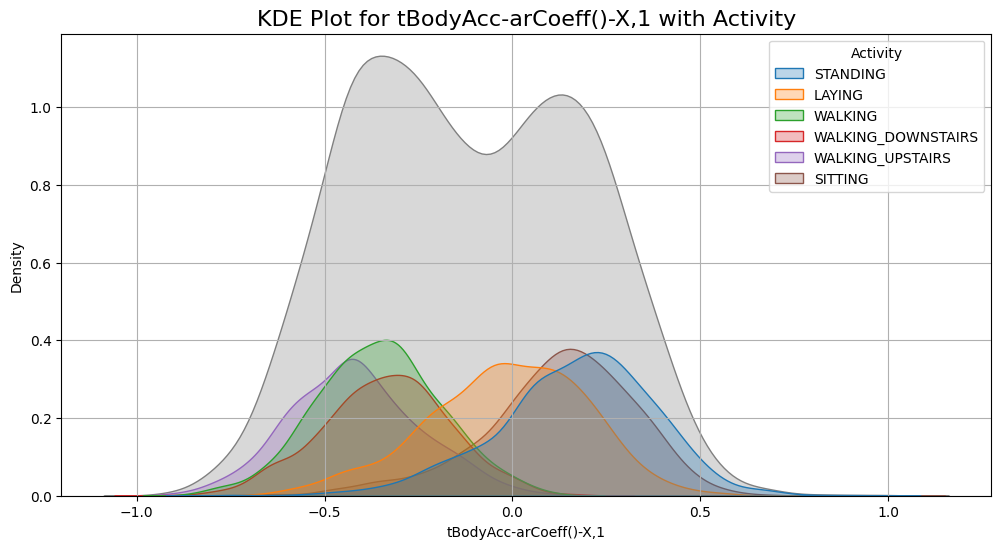

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=top5bottom5, x=bottom5name[1], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=top5bottom5, x=bottom5name[1], hue='Activity', fill=True, common_norm=True, alpha=0.3)

plt.title(f'KDE Plot for {bottom5name[1]} with Activity', fontsize=16)
plt.grid()
plt.show()



# 그래프 분포
# tBodyAcc-arCoeff()-X,1 피처에서 정적 클래스에 속하는 데이터들은 주로 양의 값을, 동적 클래스에 속하는 데이터들은 주로 음의 값으로 분포.
# 정적과 동적 클래스에 속하는 데이터의 분포가 겹쳐있는 것으로 보아 분류에 유의미하지 않은 것으로 추정.


# 도메인 지식 관점 분석
# tBodyAcc-arCoeff()-X,1: 바로 이전 몸통 가속도 값과 현재 몸통 가속도 값의 상관계수

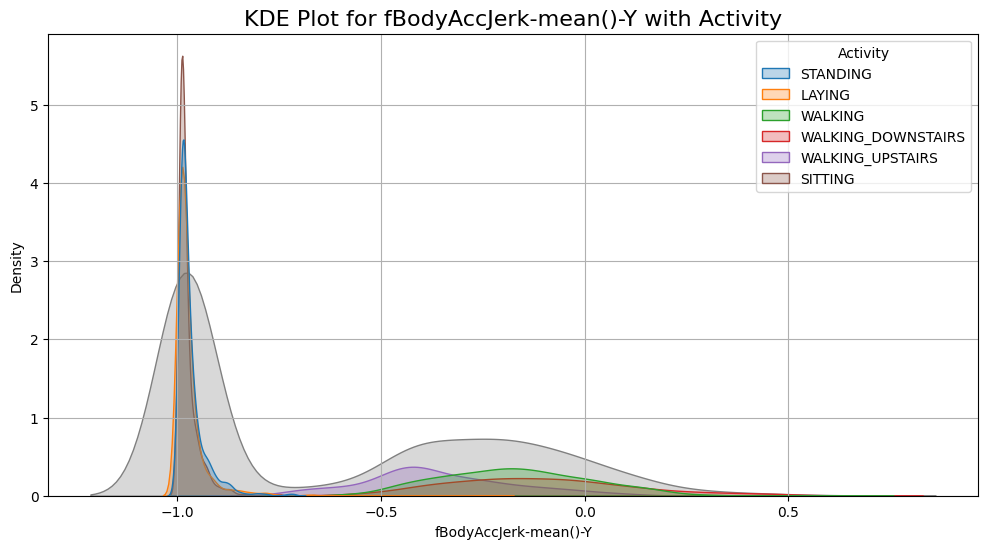

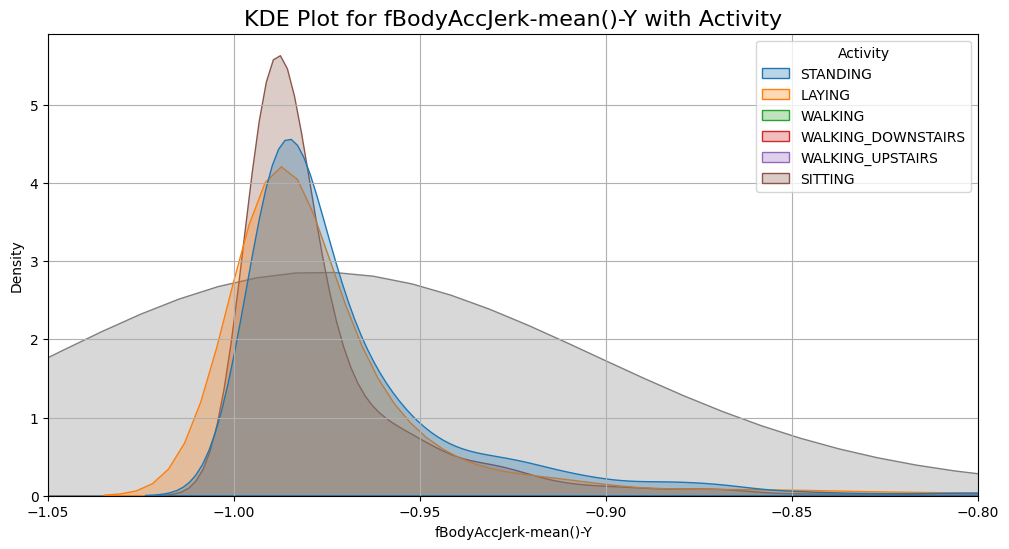

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=top5bottom5, x=bottom5name[2], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=top5bottom5, x=bottom5name[2], hue='Activity', fill=True, common_norm=True, alpha=0.3)
plt.title(f'KDE Plot for {bottom5name[2]} with Activity', fontsize=16)
plt.grid()
plt.show()


plt.figure(figsize=(12, 6))
sns.kdeplot(data=top5bottom5, x=bottom5name[2], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=top5bottom5, x=bottom5name[2], hue='Activity', fill=True, common_norm=True, alpha=0.3)
plt.xlim(-1.05, -0.8)
plt.title(f'KDE Plot for {bottom5name[2]} with Activity', fontsize=16)
plt.grid()
plt.show()


# 그래프 분포
# fBodyAccJerk-mean()-Y 피처에서 정적 클래스에 속하는 데이터들은 주로 -1값을 중심으로 좁게 밀집되어 있고, 동적 클래스에 속하는 데이터들은 주로 음의 값으로 분포되어 있는 것으로 보인다.

# 도메인 지식 관점 분석
#fBodyAccJerk-mean()-Y : y축 몸의 가속도 변화율
# 정적 클래스는 신체의 움직임이 없으므로 가속도 변화율이 낮은 것으로 추정

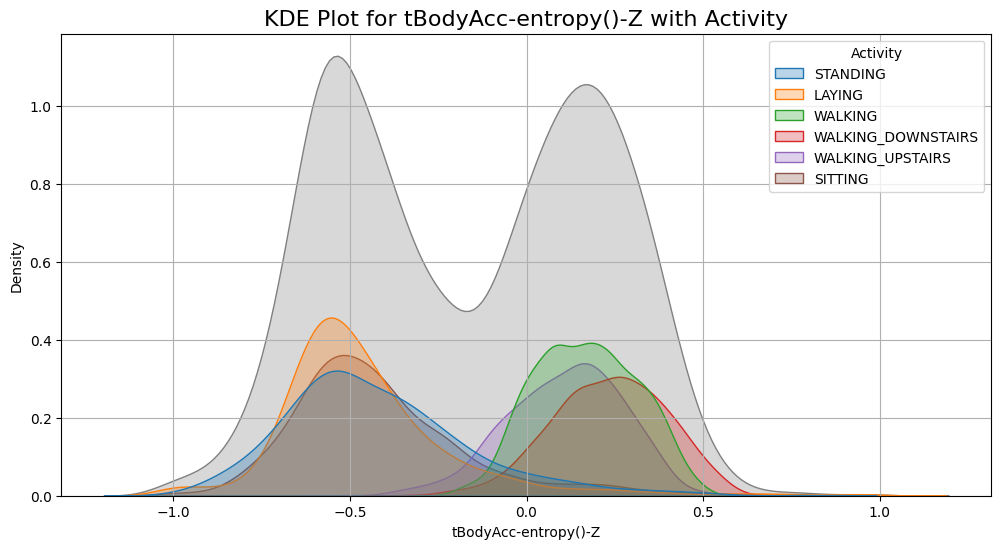

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=top5bottom5, x=bottom5name[3], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=top5bottom5, x=bottom5name[3], hue='Activity', fill=True, common_norm=True, alpha=0.3)

plt.title(f'KDE Plot for {bottom5name[3]} with Activity', fontsize=16)
plt.grid()
plt.show()


# 그래프 분포
# tBodyAcc-entropy()-Z 피처에서 정적 클래스에 속하는 데이터들은 주로 음의 값을, 동적 클래스에 속하는 데이터들은 주로 양의 값으로 분포.
# 정적과 동적 클래스에 속하는 데이터의 분포가 겹쳐있는 것으로 보아 분류에 유의미하지 않은 것으로 추정.


# 도메인 지식 관점 분석
# tBodyAcc-entropy()-Z: Z축 몸 가속도 복잡성
# 정적 클래스의 복잡성은 동적 클래스의 복잡성보다 상대적으로 낮다

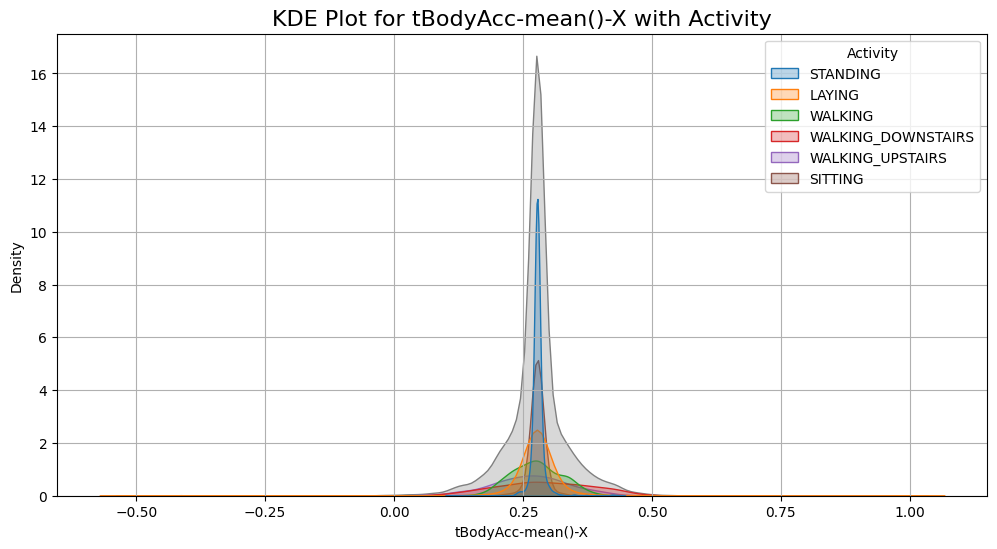

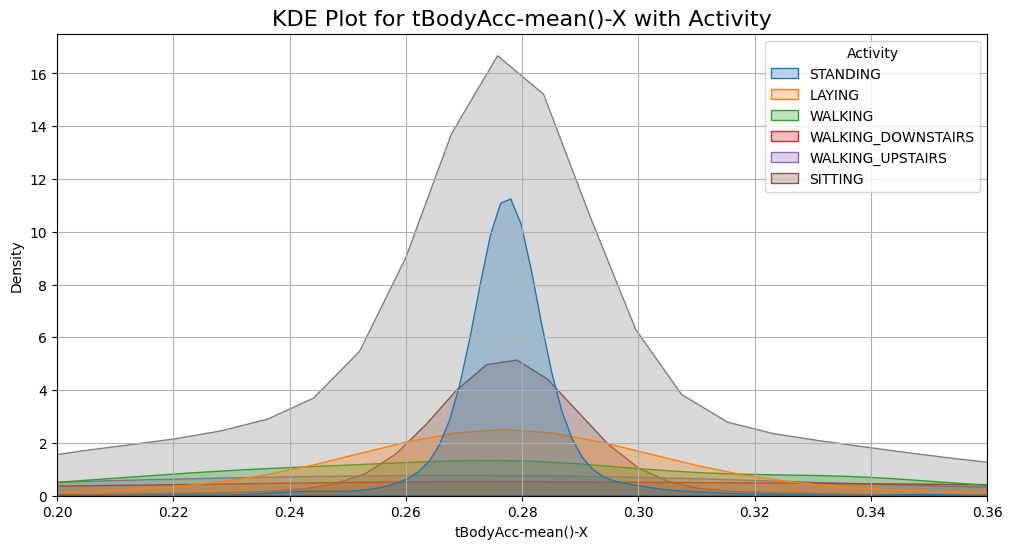

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=top5bottom5, x=bottom5name[4], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=top5bottom5, x=bottom5name[4], hue='Activity', fill=True, common_norm=True, alpha=0.3)
plt.title(f'KDE Plot for {bottom5name[4]} with Activity', fontsize=16)
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=top5bottom5, x=bottom5name[4], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=top5bottom5, x=bottom5name[4], hue='Activity', fill=True, common_norm=True, alpha=0.3)
plt.xlim(0.2, 0.36)
plt.title(f'KDE Plot for {bottom5name[4]} with Activity', fontsize=16)
plt.grid()
plt.show()


# 그래프 분포
# tBodyAcc-mean()-X 피처에서 정적/동적 클래스 모두 유사한 값 중심으로 분포되어 있으며, 정적 클래스에 속한 데이터는 동적 클래스에 속한 데이터보다 상대적으로 더 좁게 밀집되어 있다.
# 정적과 동적 클래스에 속하는 데이터의 분포가 겹쳐있어 분류에 유의미하지 않은 것으로 추정.


# 도메인 지식 관점 분석
# tBodyAcc-mean()-X: X축 몸 가속도 평균

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [ ]:
traindata['is_dynamic'] = np.where(traindata['Activity'].isin(['STANDING', 'SITTING', 'LAYING']), 0, 1)
traindata.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


In [ ]:
xd = traindata.drop(columns=['Activity', 'is_dynamic'])
yd = traindata.loc[:, 'is_dynamic']

In [ ]:
xd_train, xd_val, yd_train, yd_val = train_test_split(xd, yd, test_size=0.2, random_state=1)

#### 2) 기본모델 생성

In [ ]:
targetmodel = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=1)

targetmodel.fit(xd_train, yd_train)

dpred = targetmodel.predict(xd_val)

In [ ]:
print(confusion_matrix(yd_val, dpred))
print(classification_report(yd_val, dpred))

[[653   2]
 [  0 522]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       1.00      1.00      1.00       522

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [ ]:
#dall = plot_feature_importance(targetmodel.feature_importances_, xd_train.columns, result_only = False, topn = 'all')

,feature_name,feature_importance
0,fBodyAccJerk-mad()-X,0.069906
1,tBodyAccJerk-mad()-X,0.059914
2,tBodyAccJerk-energy()-X,0.050136
3,fBodyAccJerk-std()-X,0.050017
4,"fBodyAccJerk-bandsEnergy()-1,24",0.040111


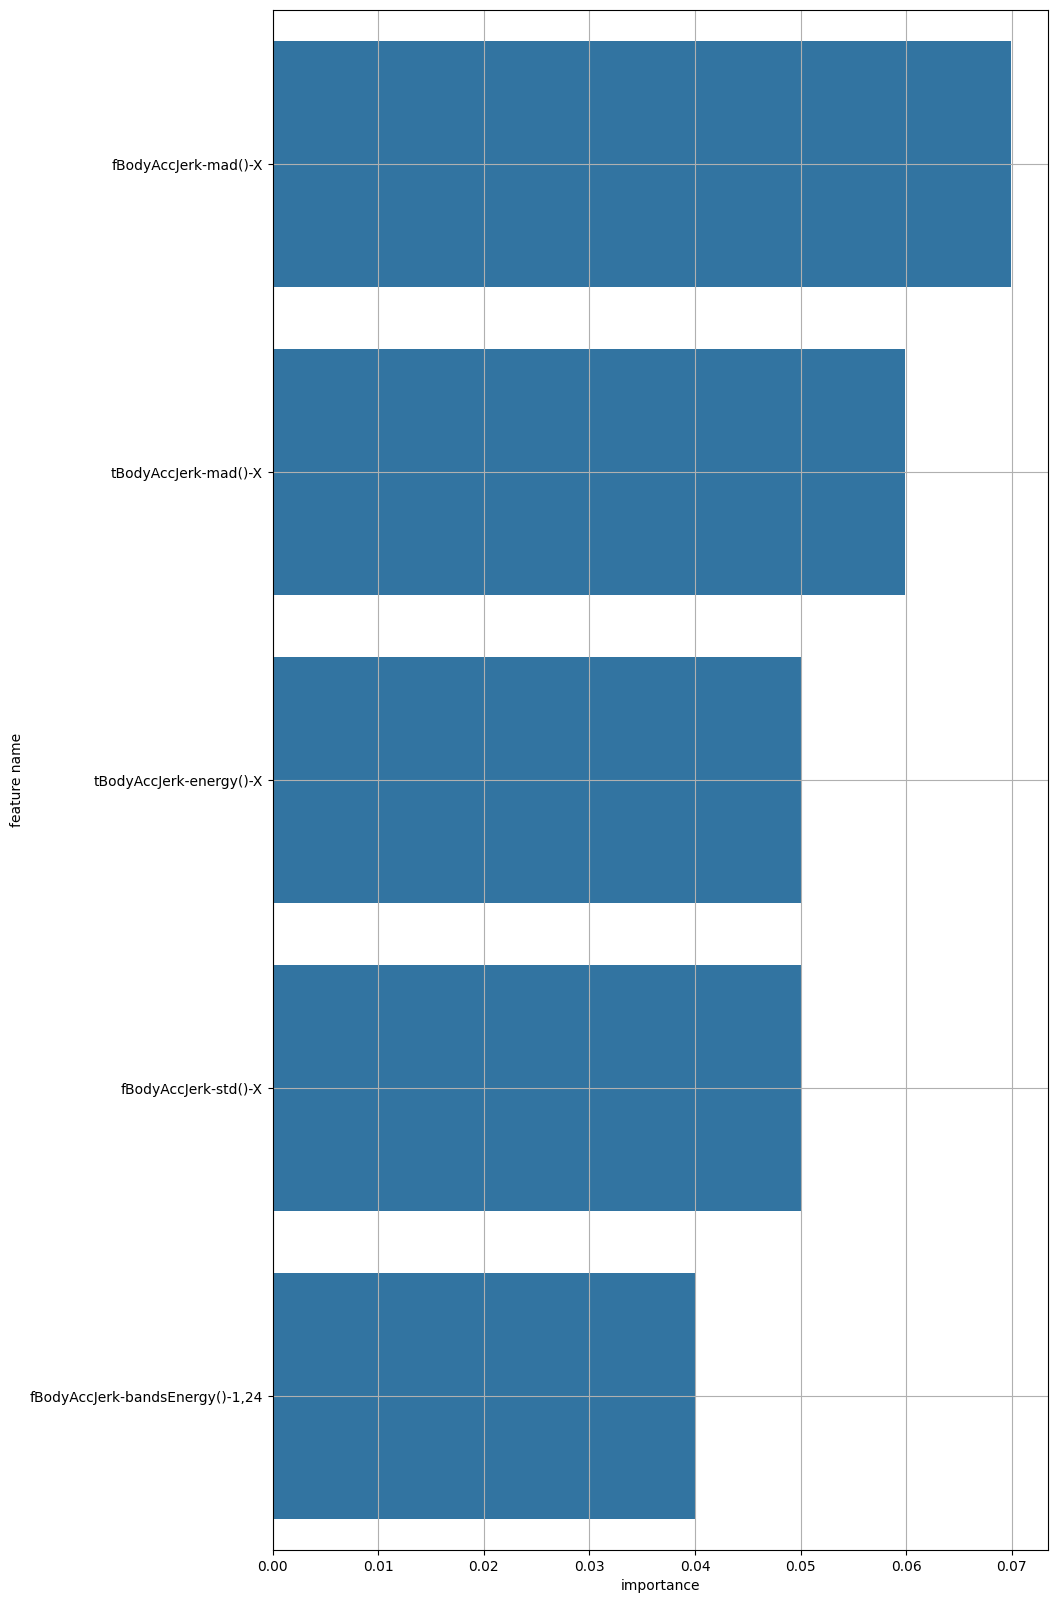

In [ ]:
dtop5 = plot_feature_importance(targetmodel.feature_importances_, xd_train.columns, result_only = False, topn = 5)
dtop5

# 정적/동적 클래스 분류에는 신체 가속도가 더 유의미한 것으로 추정

In [ ]:
# importance_dynamic = pd.DataFrame({
#     'Feature': xd_train.columns,
#     'Importance': targetmodel.feature_importances_
# }).sort_values(by='Importance', ascending=False)
# importance_dynamic

In [ ]:
dtop5name = dtop5['feature_name'].tolist()
dtop5name

['fBodyAccJerk-mad()-X',
 'tBodyAccJerk-mad()-X',
 'tBodyAccJerk-energy()-X',
 'fBodyAccJerk-std()-X',
 'fBodyAccJerk-bandsEnergy()-1,24']

In [ ]:
ddata5 = traindata[dtop5name + ['is_dynamic']]
ddata5

,fBodyAccJerk-mad()-X,tBodyAccJerk-mad()-X,tBodyAccJerk-energy()-X,fBodyAccJerk-std()-X,"fBodyAccJerk-bandsEnergy()-1,24",is_dynamic
0,-0.984298,-0.986926,-0.999830,-0.987847,-0.999880,0
1,-0.989769,-0.990986,-0.999893,-0.992979,-0.999907,0
2,-0.992122,-0.994091,-0.999948,-0.994513,-0.999972,0
3,-0.137327,-0.194729,-0.708350,-0.229423,-0.677324,1
4,-0.047394,-0.146586,-0.633311,-0.212695,-0.617120,1
...,...,...,...,...,...,...
5876,-0.990044,-0.989988,-0.999899,-0.992318,-0.999922,0
5877,-0.146317,-0.215943,-0.730615,-0.263827,-0.695289,1
5878,-0.981693,-0.984277,-0.999797,-0.986582,-0.999859,0
5879,-0.036929,-0.187882,-0.683215,-0.200845,-0.651018,1


#### 3) 변수중요도 상위 5개 분석

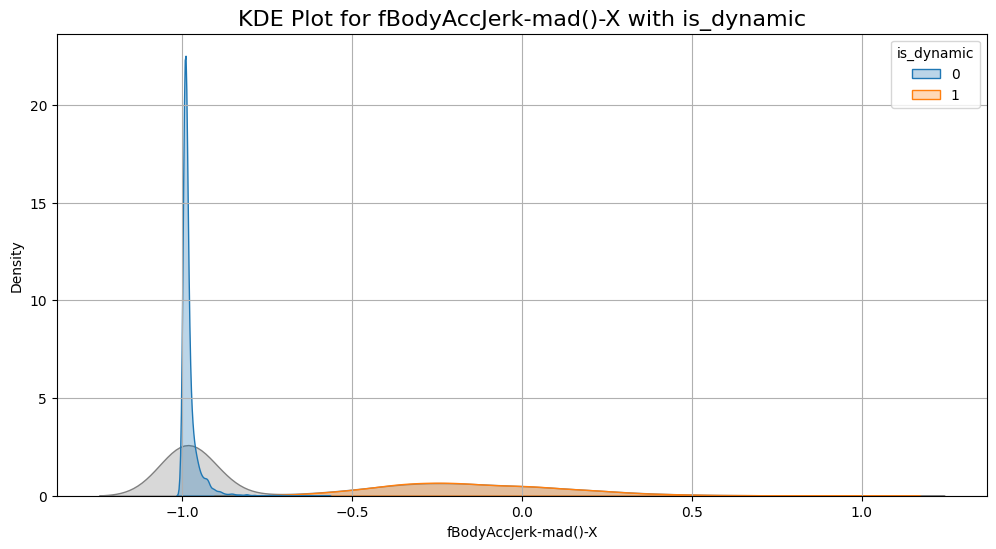

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=ddata5, x=dtop5name[0], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=ddata5, x=dtop5name[0], hue='is_dynamic', fill=True, common_norm=True, alpha=0.3)
plt.title(f'KDE Plot for {dtop5name[0]} with is_dynamic', fontsize=16)
plt.grid()
plt.show()

#그래프 분석
# 정적 데이터에 속한 데이터는 -1값에 좁게 분포되어 있으며, 동적 클래스에 속한 데이터는 넓게 분포되어 있다.
# 분포가 확실히 구분되어 분류에 유의미한 것으로 추정

#도메인 지식 관점 분석
#fBodyAccJerk-mad()-X: X축 방향 신체 가속도 변화율 평균절대편차
# 정적 클래스: 변화율이 거의 비슷하다.
# 동적 클래스: 변화율이 불규칙하다.

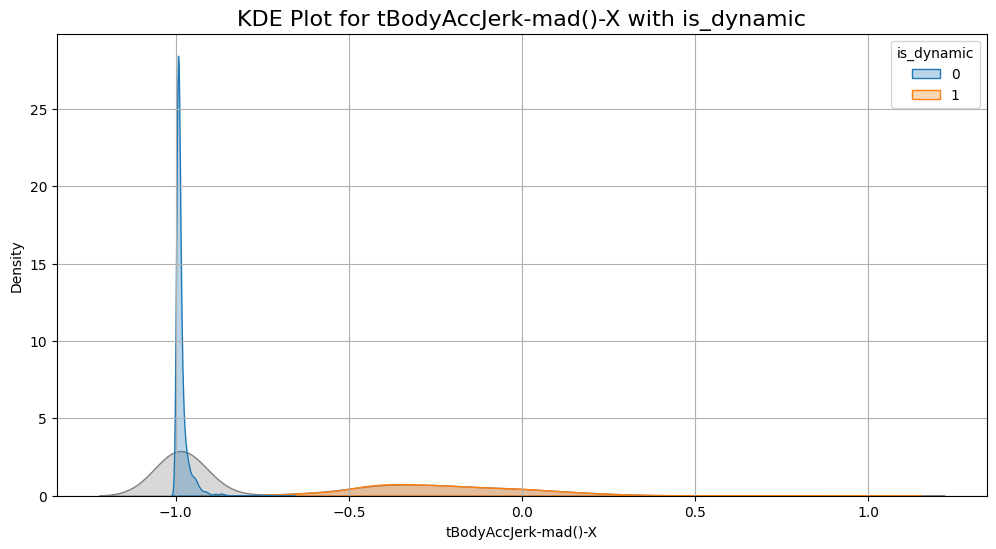

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=ddata5, x=dtop5name[1], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=ddata5, x=dtop5name[1], hue='is_dynamic', fill=True, common_norm=True, alpha=0.3)

plt.title(f'KDE Plot for {dtop5name[1]} with is_dynamic', fontsize=16)
plt.grid()
plt.show()

#위와 동일

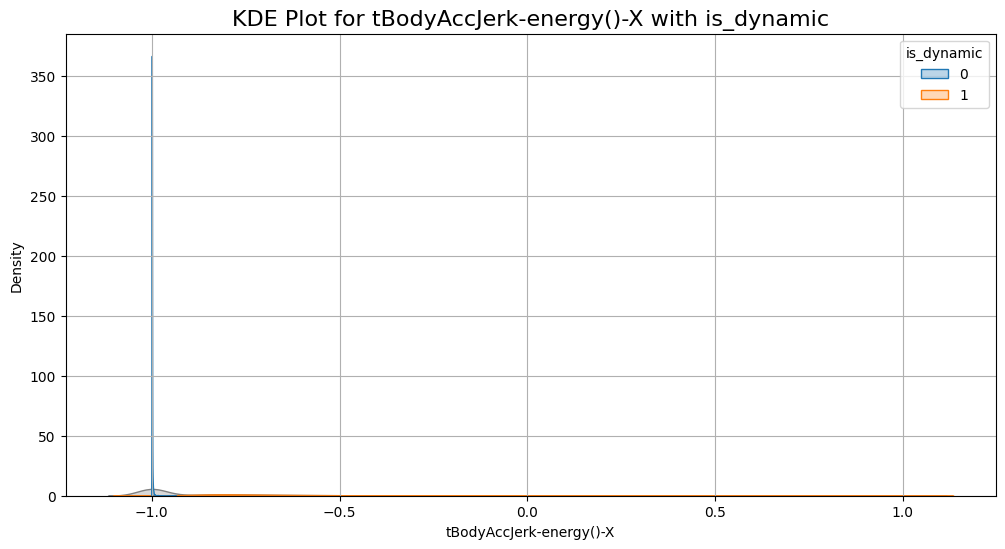

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=ddata5, x=dtop5name[2], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=ddata5, x=dtop5name[2], hue='is_dynamic', fill=True, common_norm=True, alpha=0.3)

plt.title(f'KDE Plot for {dtop5name[2]} with is_dynamic', fontsize=16)
plt.grid()
plt.show()
#위와 동일

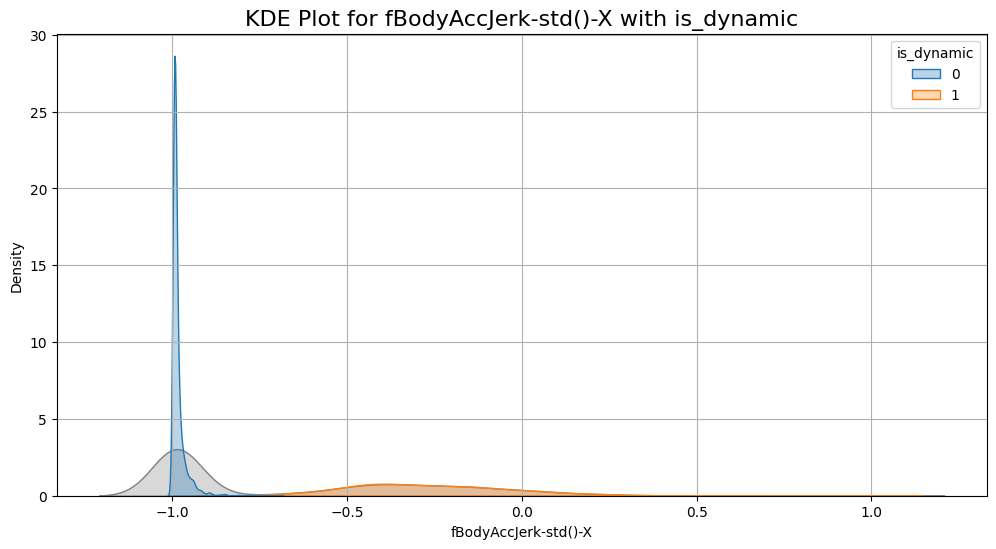

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=ddata5, x=dtop5name[3], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=ddata5, x=dtop5name[3], hue='is_dynamic', fill=True, common_norm=True, alpha=0.3)

plt.title(f'KDE Plot for {dtop5name[3]} with is_dynamic', fontsize=16)
plt.grid()
plt.show()
#위와 동일

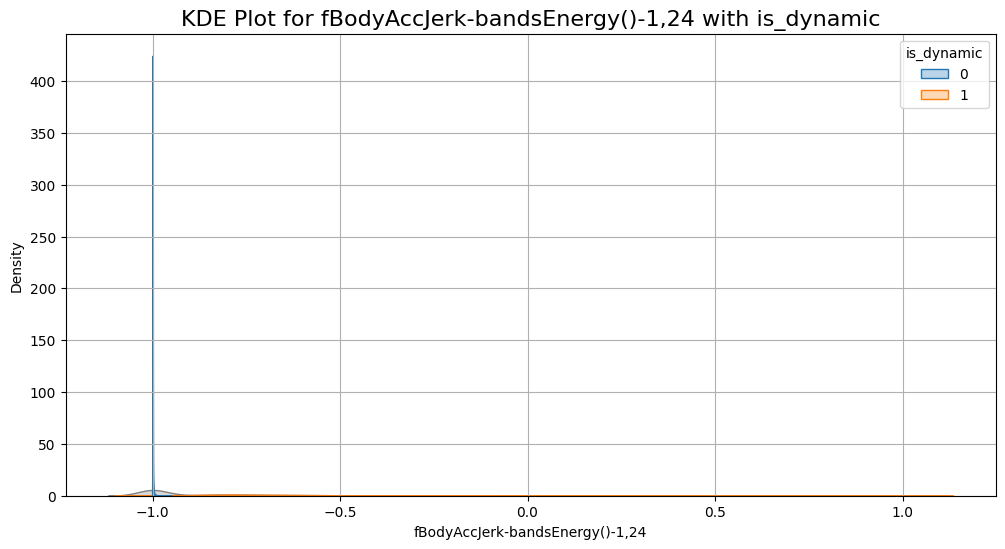

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=ddata5, x=dtop5name[4], color='gray', fill=True, common_norm=False, alpha=0.3)
sns.kdeplot(data=ddata5, x=dtop5name[4], hue='is_dynamic', fill=True, common_norm=True, alpha=0.3)

plt.title(f'KDE Plot for {dtop5name[4]} with is_dynamic', fontsize=16)
plt.grid()
plt.show()

#위와 동일


# 전반적으로 t/fBodyAcc가 중요한 피처이며, 특히 BodyAccJerk가 중요도가 높다.

#### 4) 변수그룹중요도 분석

In [ ]:
mergedata = featuresdata.merge(dall, on='feature_name', how='left')
mergedata

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000000
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000000
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000000
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.000034
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000000
...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000007
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000004
558,angle,X,gravityMean,"angle(X,gravityMean)",0.000103
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.000031


In [ ]:
# 평균 중요도의 값이 클수록 해당 센서 그룹이 is_dynamic 예측에 더 큰 영향을 미친다는 의미

Sensor별 중요도

In [ ]:
sensor_importance = mergedata.groupby('sensor')['feature_importance'].mean().sort_values(ascending=False)
print(sensor_importance)

sensor
tBodyAccJerkMag         8.449422e-03
tBodyAccJerk            6.991940e-03
fBodyAccJerk            4.558060e-03
fBodyBodyAccJerkMag     3.818394e-03
tBodyGyroJerk           1.245430e-03
fBodyAcc                1.014792e-03
tBodyGyroJerkMag        7.652038e-04
fBodyAccMag             7.598252e-04
fBodyGyro               5.055097e-04
tBodyGyro               2.577927e-04
angle                   2.326615e-05
tBodyAcc                8.727979e-06
tGravityAcc             4.456525e-06
tBodyAccMag             4.383081e-07
fBodyBodyGyroMag        0.000000e+00
fBodyBodyGyroJerkMag    0.000000e+00
tBodyGyroMag            0.000000e+00
tGravityAccMag          0.000000e+00
Name: feature_importance, dtype: float64


Sensor + agg 별 중요도

In [ ]:
pd.set_option('display.max_rows', None)

sensor_agg_importance = mergedata.groupby(['sensor', 'agg'])['feature_importance'].mean().sort_values(ascending=False)
print(sensor_agg_importance)
# BodyAcc가 주로 중요도가 높다

sensor                agg              
tBodyAccJerkMag       mean()               3.996575e-02
                      sma()                3.990858e-02
tBodyAccJerk          mad()                3.324190e-02
fBodyAccJerk          mad()                2.334459e-02
tBodyAccJerk          entropy()            2.326779e-02
                      energy()             2.000285e-02
fBodyAccJerk          std()                1.997720e-02
fBodyGyro             sma()                1.993991e-02
tBodyAccJerkMag       entropy()            1.993991e-02
fBodyBodyAccJerkMag   mean()               1.978680e-02
fBodyAccJerk          energy()             1.332761e-02
                      entropy()            1.322021e-02
tBodyAccJerk          std()                9.999917e-03
fBodyBodyAccJerkMag   mad()                9.974218e-03
tBodyAccJerkMag       mad()                9.974080e-03
fBodyAcc              mean()               9.965802e-03
fBodyAccJerk          sma()                9.965480e-03
tBodyGyr

###피처 중요도 추가 분석


sensor별 DataFrame 분리

In [ ]:
traindata = pd.read_csv(path + 'data01_train.csv')
traindata = traindata.drop(columns='subject')
data1=traindata.copy()
df_dict={}
for f in featuresdata['sensor'].unique():
  columns_=[]
  for col in data1.columns:
    if '-' in col and f == col.split('-')[0]:
      columns_.append(col)
    elif f == 'angle' and f in col:
      columns_.append(col)
  p_data=data1[columns_]
  print(f'{f}의 컬럼 개수는 {len(columns_)}')
  data1.drop(columns_,axis=1,inplace=True)
  df_dict[f] = p_data

tBodyAcc의 컬럼 개수는 40
tGravityAcc의 컬럼 개수는 40
tBodyAccJerk의 컬럼 개수는 40
tBodyGyro의 컬럼 개수는 40
tBodyGyroJerk의 컬럼 개수는 40
tBodyAccMag의 컬럼 개수는 13
tGravityAccMag의 컬럼 개수는 13
tBodyAccJerkMag의 컬럼 개수는 13
tBodyGyroMag의 컬럼 개수는 13
tBodyGyroJerkMag의 컬럼 개수는 13
fBodyAcc의 컬럼 개수는 79
fBodyAccJerk의 컬럼 개수는 79
fBodyGyro의 컬럼 개수는 79
fBodyAccMag의 컬럼 개수는 13
fBodyBodyAccJerkMag의 컬럼 개수는 13
fBodyBodyGyroMag의 컬럼 개수는 13
fBodyBodyGyroJerkMag의 컬럼 개수는 13
angle의 컬럼 개수는 7


In [ ]:
Boruta 알고리즘을 통한 변수 중요도 추출

In [ ]:
# boruta 알고리즘 실행
# #pip install scikit-learn boruta
from sklearn.ensemble import RandomForestClassifier
#from boruta import BorutaPy
import json

# important_features_dict = {}

# for name, df in df_dict.items():
#     print(f"Analyzing {name}...")
#     X = df
#     y = data['Activity']
#     rf = RandomForestClassifier(random_state=42)
#     boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42)
#     boruta_selector.fit(X.values, y.values)
#     selected_features = X.columns[boruta_selector.support_].tolist()
#     important_features_dict[name] = selected_features
#     print(f"Important features for {name}: {selected_features}")
# print("Important features across all dataframes:", important_features_dict)



# 결과 저장
# file_path = path + 'important_features_dict.json'
# with open(file_path, 'w', encoding='utf-8') as file:
#     json.dump(important_features_dict, file, ensure_ascii=False, indent=4)


# 저장된 결과 load
with open(path + 'important_features_dict.json', 'r', encoding='utf-8') as file:
    loaded_dict = json.load(file)


# 중요한 피처로 선택된 피처만 추출
for i in loaded_dict.keys():
  print(f'{i}: {len(loaded_dict[i])}')

print('==========================================================')
df_dict_boruta = {}
for name, df in df_dict.items():
    if name in loaded_dict:
        important_features = loaded_dict[name]
        df_boruta = df[important_features]
        df_dict_boruta[name] = df_boruta
    else:
        print(f"Warning: No important features found for {name}")

tBodyAcc: 40
tGravityAcc: 40
tBodyAccJerk: 40
tBodyGyro: 40
tBodyGyroJerk: 40
tBodyAccMag: 13
tGravityAccMag: 13
tBodyAccJerkMag: 13
tBodyGyroMag: 13
tBodyGyroJerkMag: 13
fBodyAcc: 70
fBodyAccJerk: 68
fBodyGyro: 76
fBodyAccMag: 13
fBodyBodyAccJerkMag: 12
fBodyBodyGyroMag: 13
fBodyBodyGyroJerkMag: 12
angle: 7


ANOVA 상관계수를 통한 중요한 피처 선택

In [ ]:
from sklearn.feature_selection import f_classif

t = 100         #임계값 설정

df_dict_ANOVA = {}
correlation_dict = {}
for name, df in df_dict_boruta.items():
    print(f"Calculating ANOVA F-value for {name}...")
    f_values, p_values = f_classif(df, traindata['Activity'])

    print(f"\n{'Feature':<25} {'F-value':<15} {'p-value'}")
    print('=' * 50)
    for col, f_val, p_val in zip(df.columns, f_values, p_values):
        print(f"{col:<25} {f_val:<15.4f} {p_val:.4e}")
    print('=' * 50)
    selected_features = [col for col, f_val in zip(df.columns, f_values) if f_val > t]
    df_anova = df[selected_features]
    df_dict_ANOVA[name] = df_anova
    print(df_anova.shape)
    print(f"ANOVA F-values for {name}, kept {len(selected_features)} features out of {df.shape[1]}")
    print('=========================================================================')

Calculating ANOVA F-value for tBodyAcc...

Feature                   F-value         p-value
tBodyAcc-mean()-X         16.2914         5.3926e-16
tBodyAcc-mean()-Y         13.6713         2.6969e-13
tBodyAcc-mean()-Z         8.2160          9.6148e-08
tBodyAcc-std()-X          14498.1972      0.0000e+00
tBodyAcc-std()-Y          9591.9416       0.0000e+00
tBodyAcc-std()-Z          4882.3851       0.0000e+00
tBodyAcc-mad()-X          12491.0064      0.0000e+00
tBodyAcc-mad()-Y          8958.0623       0.0000e+00
tBodyAcc-mad()-Z          4950.0748       0.0000e+00
tBodyAcc-max()-X          15558.7157      0.0000e+00
tBodyAcc-max()-Y          5467.8490       0.0000e+00
tBodyAcc-max()-Z          3692.1230       0.0000e+00
tBodyAcc-min()-X          8159.1227       0.0000e+00
tBodyAcc-min()-Y          5832.7843       0.0000e+00
tBodyAcc-min()-Z          3034.2942       0.0000e+00
tBodyAcc-sma()            13349.1060      0.0000e+00
tBodyAcc-energy()-X       4701.0532       0.0000e+00
tBodyA

PCA를 통한 주성분 분석

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca_results = {}
for name, df in df_dict_ANOVA.items():
    print(f"Applying PCA to {name}...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)
    pca_columns = [f'{name}_PC{i+1}' for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, columns=pca_columns)
    pca_results[name] = df_pca
    print(f"PCA applied to {name}, reduced to {df_pca.shape[1]} components.")
combined_pca = pd.concat(pca_results.values(), axis=1)
print(combined_pca.shape)
combined_pca

Applying PCA to tBodyAcc...
PCA applied to tBodyAcc, reduced to 11 components.
Applying PCA to tGravityAcc...
PCA applied to tGravityAcc, reduced to 10 components.
Applying PCA to tBodyAccJerk...
PCA applied to tBodyAccJerk, reduced to 10 components.
Applying PCA to tBodyGyro...
PCA applied to tBodyGyro, reduced to 12 components.
Applying PCA to tBodyGyroJerk...
PCA applied to tBodyGyroJerk, reduced to 9 components.
Applying PCA to tBodyAccMag...
PCA applied to tBodyAccMag, reduced to 4 components.
Applying PCA to tGravityAccMag...
PCA applied to tGravityAccMag, reduced to 4 components.
Applying PCA to tBodyAccJerkMag...
PCA applied to tBodyAccJerkMag, reduced to 3 components.
Applying PCA to tBodyGyroMag...
PCA applied to tBodyGyroMag, reduced to 3 components.
Applying PCA to tBodyGyroJerkMag...
PCA applied to tBodyGyroJerkMag, reduced to 3 components.
Applying PCA to fBodyAcc...
PCA applied to fBodyAcc, reduced to 16 components.
Applying PCA to fBodyAccJerk...
PCA applied to fBodyAcc

,tBodyAcc_PC1,tBodyAcc_PC2,tBodyAcc_PC3,tBodyAcc_PC4,tBodyAcc_PC5,tBodyAcc_PC6,tBodyAcc_PC7,tBodyAcc_PC8,tBodyAcc_PC9,tBodyAcc_PC10,...,fBodyBodyGyroMag_PC1,fBodyBodyGyroMag_PC2,fBodyBodyGyroMag_PC3,fBodyBodyGyroMag_PC4,fBodyBodyGyroJerkMag_PC1,fBodyBodyGyroJerkMag_PC2,fBodyBodyGyroJerkMag_PC3,angle_PC1,angle_PC2,angle_PC3
0,-3.699579,-0.895225,-1.152103,0.607606,-0.979043,0.320917,-0.497994,1.890403,-0.415078,0.046475,...,-2.465966,-0.507288,0.150648,0.186495,-2.226592,-0.541692,0.211592,-1.095284,0.163011,0.529105
1,-4.557698,0.340737,-0.324913,0.867124,1.077492,0.132228,-0.874078,-1.491715,-0.174610,0.272154,...,-2.489064,-0.603001,0.204750,0.263342,-2.122391,0.269324,0.266558,2.805474,1.513665,-0.645998
2,-5.442224,2.116853,0.001943,-0.271707,0.154170,-0.300118,0.521607,-0.110012,0.270208,-0.047678,...,-2.290166,2.659610,1.043691,-0.150268,-2.376122,-0.666898,0.374904,-0.728603,-0.357718,-0.175144
3,4.774446,-2.007071,0.304000,-0.461270,-0.979885,-0.438933,-0.432972,0.275448,0.024127,-0.726478,...,1.639708,0.530175,-0.202553,0.078692,1.703630,1.004391,-0.339023,-1.014783,0.017903,0.271392
4,5.021029,0.425779,-1.414909,0.620370,-2.017284,-1.957605,1.881570,-0.421516,-0.827497,0.669120,...,2.718333,-1.527972,0.104188,0.447983,0.833923,0.380356,-0.603428,-1.033181,0.126627,0.219309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,-3.970310,-0.425934,-0.182088,-0.767702,0.847938,-0.977836,0.973495,-1.412739,0.395626,0.431989,...,-2.491541,-0.391878,0.412382,0.336598,-2.182597,0.127126,0.339707,-0.866882,0.074683,-0.441075
5877,3.772597,1.079328,0.901910,-1.334406,-1.356967,-0.317116,-0.169402,-0.745776,-0.430855,0.501039,...,2.745537,-1.825435,0.576916,-0.285441,0.350729,-1.320127,-0.765830,-0.736572,-0.469376,0.252926
5878,-4.847803,0.349490,-0.085697,0.673948,1.223518,-0.145222,-0.500767,-0.439903,0.145279,-0.792539,...,-2.617377,1.047996,-1.152255,-0.950129,-2.392823,-0.932194,0.360163,3.300368,-0.121608,0.322029
5879,4.521633,-1.115887,3.301818,-1.066906,-3.203300,-0.697457,0.084911,-0.323351,-0.255966,-0.515425,...,1.733212,-1.135865,-0.047080,-0.394709,1.627051,2.265424,-0.402725,-0.883589,-0.262326,0.217043


모델 학습

In [ ]:
y=np.where(traindata['Activity'].isin(['STANDING', 'SITTING', 'LAYING']),0,1)
from sklearn.model_selection import train_test_split as tts
x_train,x_test,y_train,y_test=tts(combined_pca,y,test_size=0.3,random_state=42,stratify=y,shuffle=True)
targetmodel = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=1)
targetmodel.fit(x_train, y_train)
dpred = targetmodel.predict(x_test)

결과 확인

           feature_name  feature_importance
0      tBodyAccJerk_PC1            0.163543
1   tBodyAccJerkMag_PC1            0.129467
2     tBodyGyroJerk_PC1            0.086576
3         fBodyGyro_PC1            0.074689
4  tBodyGyroJerkMag_PC1            0.064439
[[969   2]
 [  0 794]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       971
           1       1.00      1.00      1.00       794

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



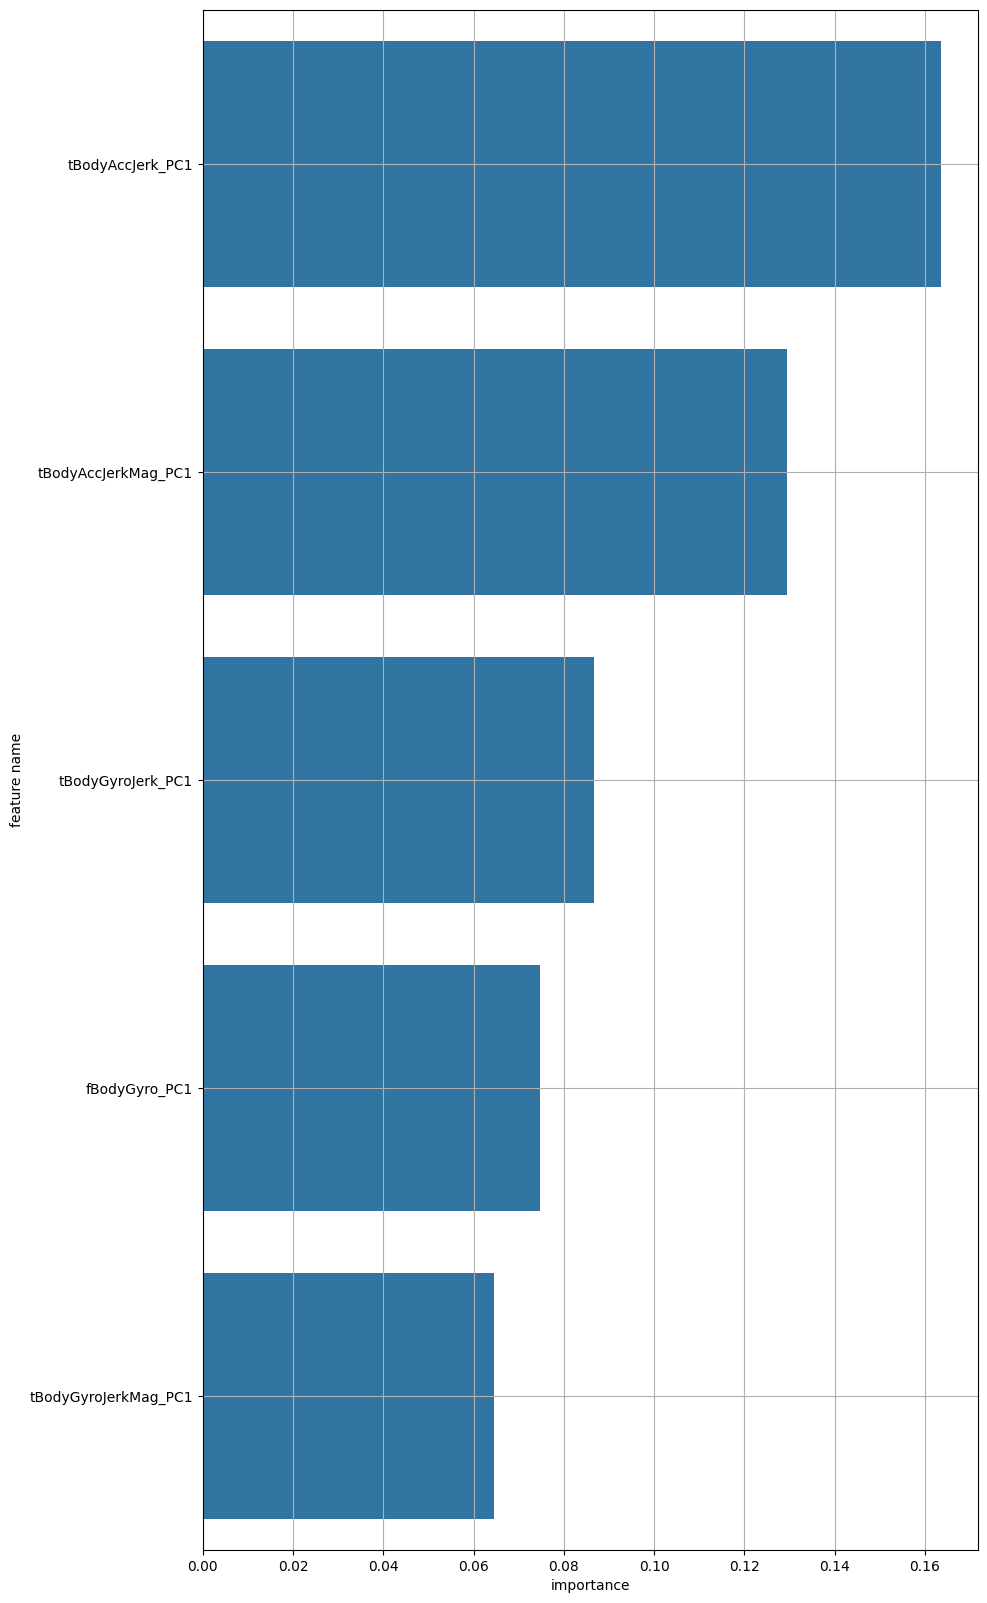

In [ ]:
dtop5 = plot_feature_importance(targetmodel.feature_importances_, x_train.columns, result_only = False, topn = 5)
print(dtop5)
print(confusion_matrix(y_test, dpred))
print(classification_report(y_test, dpred))
# 이전 분석 결과와 동일하게 나온 것을 확인
# Test 결과, 두 클래스 모두 정확도 1을 확인